In [1]:
import os
import shutil
from pathlib import Path

from PIL import Image

import torch
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms.v2 as transforms
import torch.nn as nn 
import torch.optim as optim
import tqdm

import random

from torch.utils.tensorboard import SummaryWriter

In [8]:
output_dir = 'dataset'

for part in ['train', 'test']:
    for cls in ['cats', 'dogs']:
        os.makedirs(os.path.join(output_dir, part, cls), exist_ok=True)

In [10]:
def copy_files(src_dir, data_train, data_test, ratio):
    files = [f for f in os.listdir(src_dir)]
    random.shuffle(files)
    split_idx = int(len(files) * ratio)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(data_train, f))
    for f in test_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(data_test, f))

In [12]:
train_cats = os.path.join(output_dir, 'train', 'cats')
test_cats = os.path.join(output_dir, 'test', 'cats')
train_dogs = os.path.join(output_dir, 'train', 'dogs')
test_dogs = os.path.join(output_dir, 'test', 'dogs')

cats_dir = 'src/PetImages/Cat'
dogs_dir = 'src/PetImages/Dog'

copy_files(cats_dir, train_cats, test_cats, 0.8)
copy_files(dogs_dir, train_dogs, test_dogs, 0.8)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
train_dataset = datasets.ImageFolder(root='dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/test', transform=transform)

train_dataloader = data.DataLoader(train_dataset, batch_size=32, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, num_workers=4)

In [19]:
model_lenet5 = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(44944, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 2)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.3611333].


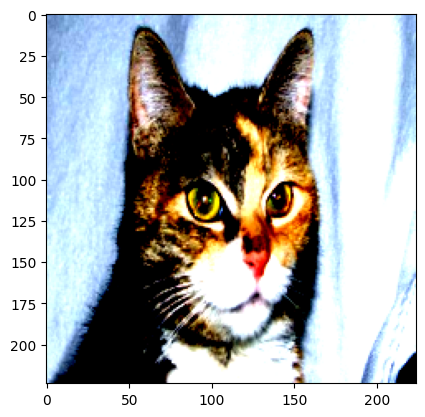

In [28]:
import matplotlib.pyplot as plt

image, label = train_dataset[10]
image_np = image.permute(1, 2, 0).numpy()
plt.imshow(image_np)

In [29]:
optimizer = optim.Adam(params=model_lenet5.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

In [30]:
epochs = 5
model_lenet5 = model_lenet5.to(device)
model_lenet5.train()

for epoch in range(epochs):
    model_lenet5.train() 
    running_loss = 0.0
    correct = 0
    total = 0

    train_tqdm = tqdm.tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
    for batch_idx, (images, labels) in enumerate(train_tqdm):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model_lenet5(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_tqdm.set_postfix(
            loss=running_loss/(batch_idx+1),
            acc=correct / total
        )

Epoch 5/5: 100%|██████████| 625/625 [00:36<00:00, 17.16it/s, acc=0.973, loss=0.0709]


In [31]:
model_lenet5.eval()

correct = 0
total = 0
total_loss = 0.0

with torch.no_grad():
    test_tqdm = tqdm.tqdm(test_dataloader, leave=True)
    for images, labels in test_tqdm:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_lenet5(images)
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
avg_test_loss = total_loss / len(test_dataloader)

print(f'Test Accuracy: {test_accuracy:.4f}%')
print(f'Average Test Loss: {avg_test_loss:.4f}')

100%|██████████| 157/157 [00:15<00:00, 10.32it/s]

Test Accuracy: 0.5000%
Average Test Loss: 5.7876


In [13]:
model_alexnet = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(384),
    nn.ReLU(),

    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(384),
    nn.ReLU(),

    nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Flatten(),

    nn.Dropout(0.5),
    nn.Linear(9216, 4096),
    nn.ReLU(),

    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),

    nn.Linear(4096, 2)
)

In [8]:
optimizer = optim.Adam(params=model_alexnet.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

In [9]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [10]:
train_dataset_al = datasets.ImageFolder(root='dataset/train', transform=transform)
test_dataset_al = datasets.ImageFolder(root='dataset/test', transform=transform)

train_dataloader_al = data.DataLoader(train_dataset_al, batch_size=32, num_workers=4)
test_dataloader_al = data.DataLoader(test_dataset_al, batch_size=32, num_workers=4)

In [14]:
epochs = 10
model_alexnet = model_alexnet.to(device)
model_alexnet.train()

writer = SummaryWriter('runs/alexnet_cats_vs_dogs')

global_step = 0

for epoch in range(epochs):
    model_alexnet.train() 
    running_loss = 0.0
    correct = 0
    total = 0

    train_tqdm = tqdm.tqdm(train_dataloader_al, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
    for batch_idx, (images, labels) in enumerate(train_tqdm):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model_alexnet(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_tqdm.set_postfix(
            loss=running_loss/(batch_idx+1),
            acc=correct / total
        )

        if global_step % 10 == 0: 
            writer.add_scalar('Training Loss', loss.item(), global_step)
            writer.add_scalar('Training Accuracy', correct / total, global_step)

        global_step += 1

    epoch_loss = running_loss / len(train_dataloader_al)
    epoch_acc = correct / total
    writer.add_scalar('Epoch Loss', epoch_loss, epoch)
    writer.add_scalar('Epoch Accuracy', epoch_acc, epoch)

writer.close()

Epoch 10/10: 100%|██████████| 625/625 [00:48<00:00, 12.84it/s, acc=0.502, loss=0.707]


In [16]:
model_alexnet.eval()

correct = 0
total = 0
total_loss = 0.0

with torch.no_grad():
    test_tqdm = tqdm.tqdm(test_dataloader_al, leave=True)
    for images, labels in test_tqdm:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_alexnet(images)
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
avg_test_loss = total_loss / len(test_dataloader_al)

print(f'Test Accuracy: {test_accuracy:.4f}%')
print(f'Average Test Loss: {avg_test_loss:.4f}')

100%|██████████| 157/157 [00:14<00:00, 10.74it/s]

Test Accuracy: 0.4976%
Average Test Loss: 0.6947
